In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Pre-processing

In [2]:
data = pd.read_csv(r"kidney_disease.csv")
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
data.describe(include = 'all')

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,248,335,396,396,...,330,295,270,398,398,398,399,399,399,400
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,...,44,92,49,2,5,3,2,2,2,3
top,NaN,NaN,NaN,NaN,NaN,NaN,normal,normal,notpresent,notpresent,...,41,9800,5.2,no,no,no,good,no,no,ckd
freq,NaN,NaN,NaN,NaN,NaN,NaN,201,259,354,374,...,21,11,18,251,258,362,317,323,339,248
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [5]:
df = data 

## Handling missing values

 We have many approaches depends on feature type (continous or categorical) and frature distribution.

  - Continuous : 
     
      - `Mean` : in case of normal distribution

      - `Midian` : if there are outliers (less sensitive to extrem values)

  - Categorical :

      - Replace with mode

  If there are a lot of missing values (>35%) we will remove the correspondance column        

In [6]:
# Drop 'id' column as it's not useful
df.drop(columns=['id'], inplace=True, errors='ignore')

In [7]:
missing_threshold = 0.35
missing_columns = df.columns[df.isnull().mean() > missing_threshold]
print("Columns with more than 35% missing values:", missing_columns)

Columns with more than 35% missing values: Index(['rbc'], dtype='object')


<Axes: xlabel='rbc'>

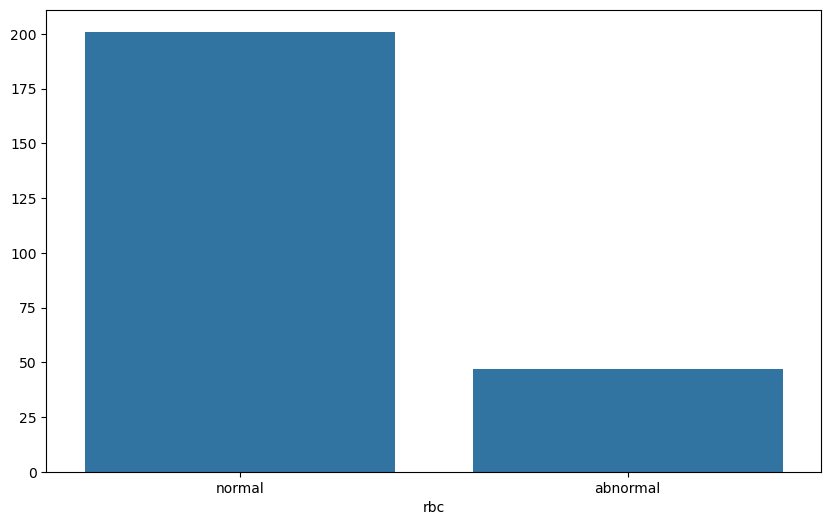

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x = df['rbc'].value_counts().index, y = df['rbc'].value_counts().values)

**Note**:
  
  - As we see `rbc` feature is unbalanced and containe more then than `35%` missing values so we will remove it.

In [9]:
df.drop(columns=['rbc'], inplace=True, errors='ignore')

In [10]:
# Seperate continuous and categorical features
categorical_features = [col for col in df.columns if df[col].nunique() < 10]
continuous_features = [col for col in df.columns if df[col].nunique() >= 10]

print("Categorical Features:", categorical_features)
print("Continuous Features:", continuous_features)

Categorical Features: ['sg', 'al', 'su', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
Continuous Features: ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']


### Continuous features

In [11]:
# Detect the normalized features using shapiro test and p-value since is better for small datasets

from scipy.stats import shapiro

normalized_features = []
for col in continuous_features:
    numeric_col = pd.to_numeric(df[col], errors='coerce').dropna()
    stat, p = shapiro(numeric_col)
    if p > 0.05:
        normalized_features.append(col)

print("Normalized Features:", normalized_features)

Normalized Features: []


In [12]:
for feature in continuous_features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')
    df[feature].fillna(df[feature].median(), inplace=True)

In [13]:
for feature in categorical_features:
    df[feature].fillna(df[feature].mode()[0], inplace=True)

In [14]:
df.isnull().sum()

age               0
bp                0
sg                0
al                0
su                0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

In [15]:

###  Feature Importance Analysis
# Encode categorical variables for feature importance analysis
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# EDA

In [42]:
# Summary statistics
print("\n🔹 Summary Statistics:\n")
df.describe()


🔹 Summary Statistics:



,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,2.542500,0.90000,0.395000,0.810000,0.105000,0.055000,145.062500,56.693000,...,39.082500,8298.500000,4.737750,0.367500,3.300000,1.080000,0.205000,0.190000,0.150000,0.755000
std,16.982996,13.489785,1.086806,1.31313,1.040038,0.392792,0.306937,0.228266,75.260774,49.395258,...,8.162245,2529.593814,0.841439,0.482728,0.579517,0.289499,0.404207,0.392792,0.357519,0.968152
min,2.000000,50.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,22.000000,1.500000,...,9.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,70.000000,2.000000,0.00000,0.000000,1.000000,0.000000,0.000000,101.000000,27.000000,...,34.000000,6975.000000,4.500000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,80.000000,3.000000,0.00000,0.000000,1.000000,0.000000,0.000000,121.000000,42.000000,...,40.000000,8000.000000,4.800000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,80.000000,3.000000,2.00000,0.000000,1.000000,0.000000,0.000000,150.000000,61.750000,...,44.000000,9400.000000,5.100000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,2.000000
max,90.000000,180.000000,4.000000,5.00000,5.000000,1.000000,1.000000,1.000000,490.000000,391.000000,...,54.000000,26400.000000,8.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,2.000000


<Figure size 1500x1000 with 0 Axes>

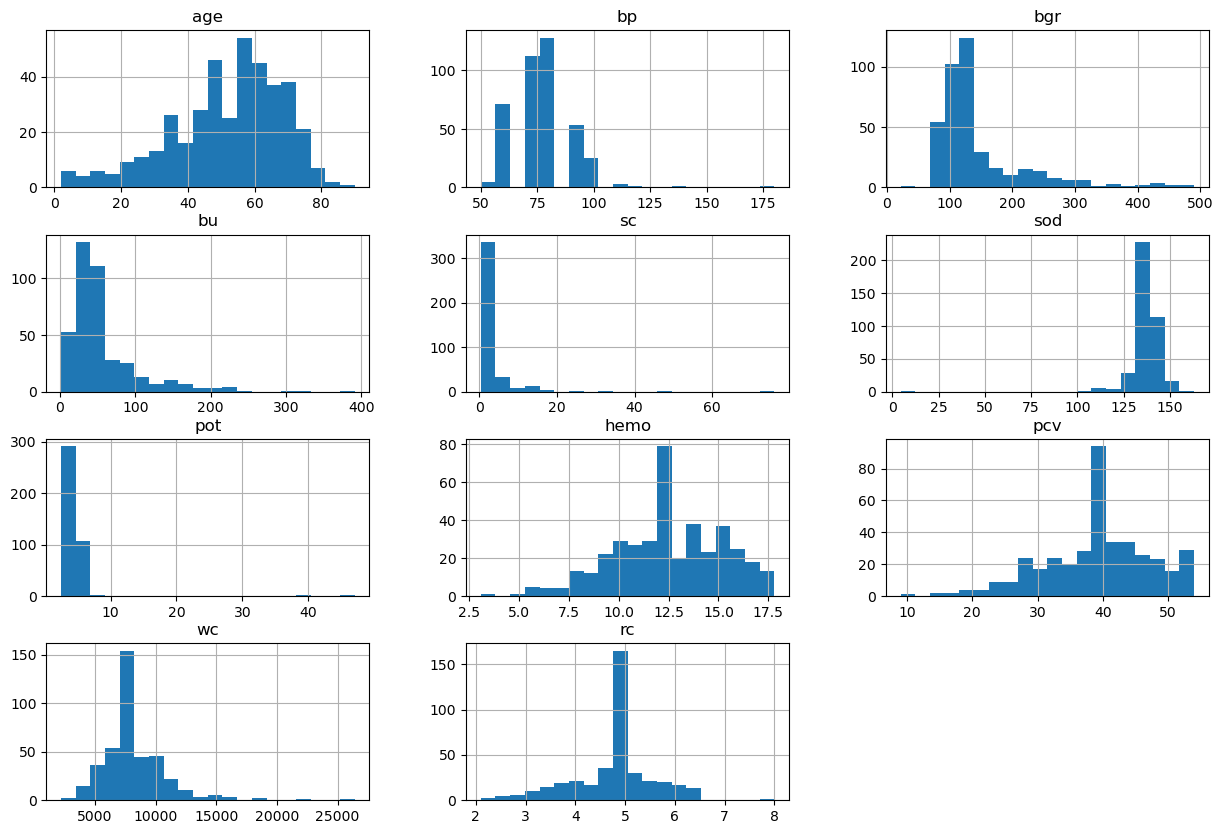

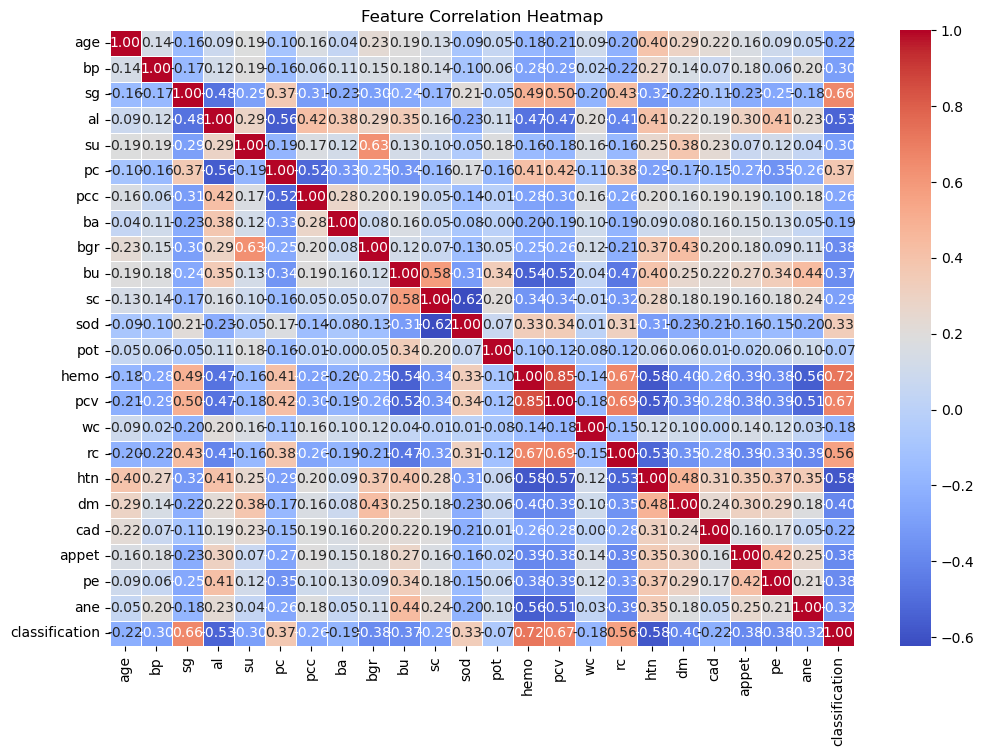

In [43]:


# Plot feature distributions
plt.figure(figsize=(15, 10))
df[continuous_features].hist(bins=20, figsize=(15, 10), layout=(4, 3))
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Variance Threshold (Low Variance Feature Removal)
selector = VarianceThreshold(threshold=0.01)
df_selected = pd.DataFrame(selector.fit_transform(df), columns=df.columns[selector.get_support()])

**Note** we will assume that `classification` is the target variable

In [34]:
df_selected['classification'].value_counts()

classification
0.0    248
2.0    150
1.0      2
Name: count, dtype: int64

In [ ]:
# Compute Mutual Information
if 'classification' in df.columns:
    mi_scores = mutual_info_classif(df.drop(columns=['classification']), df['classification'])
    mi_df = pd.DataFrame({'Feature': df.drop(columns=['classification']).columns, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by='MI Score', ascending=False)
    print("\n🔹 Mutual Information Scores:\n")
    
mi_df


🔹 Mutual Information Scores:



,Feature,MI Score
13,hemo,0.424576
14,pcv,0.421264
10,sc,0.382898
16,rc,0.360621
2,sg,0.305102
18,dm,0.277190
11,sod,0.259091
17,htn,0.253475
3,al,0.243207
12,pot,0.200204


**Result**: `hemo` and `pcv` both have the highest MI score, meaning it is the most informative feature for classification.

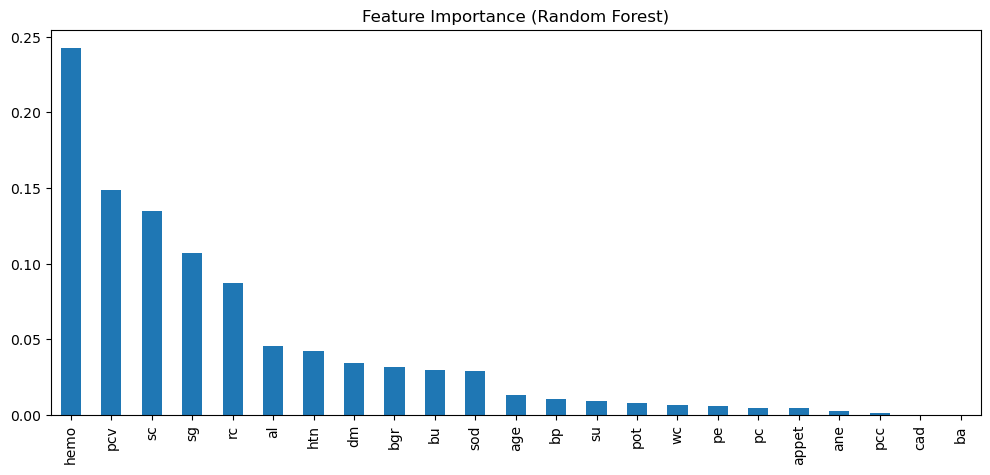

In [39]:
# Compute Mutual Information (Categorical Features)

# Feature Importance using Random Forest
if 'classification' in df.columns:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(df.drop(columns=['classification']), df['classification'])
    feature_importance = pd.Series(model.feature_importances_, index=df.drop(columns=['classification']).columns)
    feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Feature Importance (Random Forest)")
    plt.show()

#### VIF

  - **VIF** measures how much a feature is correlated with other features in a dataset.

  - High VIF (>5 or 10) means a feature is highly correlated with others → Possible multicollinearity.

  - Low VIF (~1) means little to no correlation → Good for model stability.

In [42]:
# VIF (Multicollinearity Check)
vif_data = pd.DataFrame()
vif_data["Feature"] = df_selected.columns
vif_data["VIF"] = [variance_inflation_factor(df_selected.values, i) for i in range(df_selected.shape[1])]
print("\n🔹 Variance Inflation Factor (VIF):\n")
vif_data.sort_values(by='VIF', ascending=False)


🔹 Variance Inflation Factor (VIF):



,Feature,VIF
11,sod,182.747466
13,hemo,108.125484
14,pcv,102.542342
16,rc,71.283034
18,dm,48.545932
1,bp,37.213442
19,cad,17.837834
0,age,13.369039
2,sg,13.220230
15,wc,13.065119


# PCA 

## Standerdizing

In [45]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

In [46]:
df_scaled

array([[-0.21003135,  0.25421378,  0.4214856 , ..., -0.4843221 ,
        -0.42008403, -0.78081285],
       [-2.62723421, -1.97247624,  0.4214856 , ..., -0.4843221 ,
        -0.42008403, -0.78081285],
       [ 0.615355  ,  0.25421378, -1.4210744 , ..., -0.4843221 ,
         2.38047614, -0.78081285],
       ...,
       [-2.33245337,  0.25421378,  0.4214856 , ..., -0.4843221 ,
        -0.42008403,  1.28756556],
       [-2.03767254, -1.23024623,  1.3427656 , ..., -0.4843221 ,
        -0.42008403,  1.28756556],
       [ 0.37953033,  0.25421378,  1.3427656 , ..., -0.4843221 ,
        -0.42008403,  1.28756556]])

### COV matrix

In [47]:
cov_matrix = np.cov(df_scaled.T) 
cov_matrix_pd = pd.DataFrame(cov_matrix, columns=df_selected.columns, index=df_selected.columns)
cov_matrix_pd

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
age,1.002506,0.136658,-0.160776,0.086133,0.187218,-0.102543,0.157796,0.042533,0.231309,0.194778,...,-0.213329,0.094030,-0.203708,0.396064,0.293711,0.224857,0.156974,0.095010,0.053071,-0.223544
bp,0.136658,1.002506,-0.167399,0.123827,0.190036,-0.156623,0.056950,0.110440,0.150556,0.181294,...,-0.289962,0.022232,-0.219867,0.267570,0.144951,0.070514,0.175493,0.057044,0.195623,-0.297356
sg,-0.160776,-0.167399,1.002506,-0.481165,-0.292785,0.366268,-0.307194,-0.232285,-0.300163,-0.245609,...,0.497678,-0.195557,0.433305,-0.324454,-0.223800,-0.106690,-0.231554,-0.254440,-0.184616,0.659458
al,0.086133,0.123827,-0.481165,1.002506,0.288472,-0.563121,0.418915,0.378882,0.293885,0.348289,...,-0.474632,0.203428,-0.406107,0.407075,0.224517,0.192993,0.303905,0.412111,0.230132,-0.533218
su,0.187218,0.190036,-0.292785,0.288472,1.002506,-0.190539,0.168512,0.119698,0.628574,0.127215,...,-0.181739,0.157041,-0.162400,0.254905,0.381851,0.228315,0.069389,0.116734,0.042570,-0.297663
pc,-0.102543,-0.156623,0.366268,-0.563121,-0.190539,1.002506,-0.521421,-0.331229,-0.248286,-0.345365,...,0.419483,-0.107000,0.382906,-0.292450,-0.167776,-0.152901,-0.275674,-0.351105,-0.261219,0.372506
pcc,0.157796,0.056950,-0.307194,0.418915,0.168512,-0.521421,1.002506,0.275772,0.195712,0.189568,...,-0.297323,0.163624,-0.264472,0.196114,0.161029,0.187753,0.190163,0.104618,0.176302,-0.259657
ba,0.042533,0.110440,-0.232285,0.378882,0.119698,-0.331229,0.275772,1.002506,0.079361,0.162082,...,-0.189895,0.105011,-0.192694,0.089269,0.083572,0.161210,0.149500,0.135070,0.052339,-0.188842
bgr,0.231309,0.150556,-0.300163,0.293885,0.628574,-0.248286,0.195712,0.079361,1.002506,0.119157,...,-0.258847,0.120182,-0.214630,0.368738,0.429551,0.205382,0.177729,0.095043,0.112731,-0.379444
bu,0.194778,0.181294,-0.245609,0.348289,0.127215,-0.345365,0.189568,0.162082,0.119157,1.002506,...,-0.524402,0.038458,-0.466409,0.396593,0.254415,0.215839,0.274810,0.339589,0.437415,-0.372467


In [48]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eigenvalues

array([7.32872906, 1.89997784, 1.66326673, 1.32871706, 1.22194527,
       1.08873999, 1.00241909, 0.92253506, 0.88644647, 0.8243581 ,
       0.78622891, 0.13231238, 0.67555155, 0.61565801, 0.56004649,
       0.22061967, 0.23590001, 0.48936503, 0.28820225, 0.32793628,
       0.33650103, 0.43857144, 0.40804522, 0.37807743])

In [50]:
eigenvectors.shape

(24, 24)

In [ ]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df_scaled) 

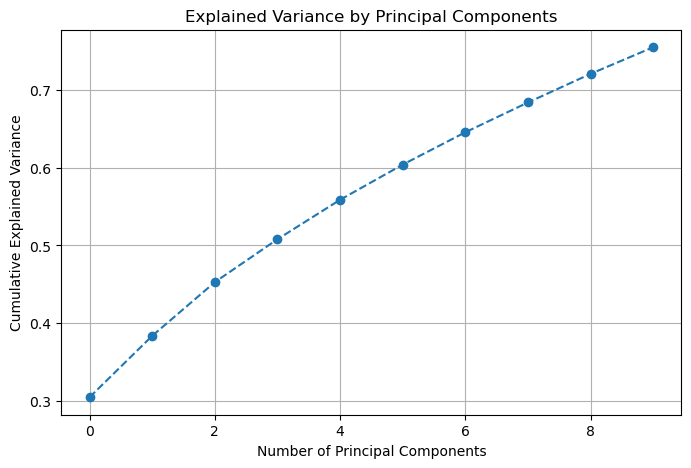

In [52]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.grid()
plt.show()

In [58]:
optimal_pcs = np.argmax(cumulative_variance >= 0.8) + 1  # Keep 95% variance

pca_opt = PCA(n_components=optimal_pcs)
df_pca_opt = pca_opt.fit_transform(df_scaled)

print(f"✅ Keeping {optimal_pcs} principal components.")


✅ Keeping 1 principal components.


In [59]:
for i, (ev, cv) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"PC{i+1}: {ev:.4f} (Individual) | {cv:.4f} (Cumulative)")

PC1: 0.3046 (Individual) | 0.3046 (Cumulative)
PC2: 0.0790 (Individual) | 0.3836 (Cumulative)
PC3: 0.0691 (Individual) | 0.4527 (Cumulative)
PC4: 0.0552 (Individual) | 0.5079 (Cumulative)
PC5: 0.0508 (Individual) | 0.5587 (Cumulative)
PC6: 0.0453 (Individual) | 0.6040 (Cumulative)
PC7: 0.0417 (Individual) | 0.6456 (Cumulative)
PC8: 0.0383 (Individual) | 0.6840 (Cumulative)
PC9: 0.0368 (Individual) | 0.7208 (Cumulative)
PC10: 0.0343 (Individual) | 0.7551 (Cumulative)


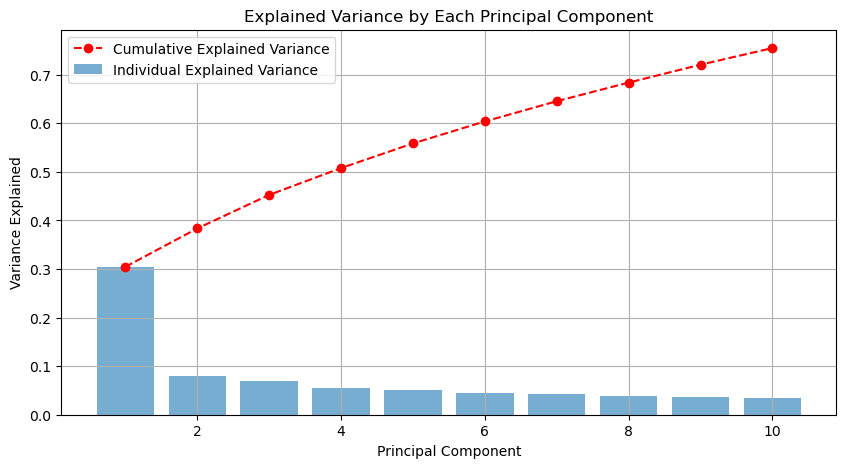

In [60]:
plt.figure(figsize=(10, 5))

# Plot individual explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label="Individual Explained Variance")

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red', label="Cumulative Explained Variance")

plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by Each Principal Component")
plt.legend()
plt.grid()
plt.show()


**Interpretations** :

 -  PC1 alone explains ~30.46% of variance → This means one feature alone captures 30% of the total information in the dataset.
 -  PC2 adds ~7.9%, making cumulative variance 38.36% → The first two PCs together explain ~38.36% of the dataset's variance.
 -  PC10 cumulatively captures ~75.51% of total variance → If we reduce dimensions to 10 PCs, we retain ~75.51% of the dataset’s information.



In [63]:
pca_df = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(df_pca.shape[1])])

In [64]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.698580,0.303834,0.932266,-0.519246,-0.045108,-0.075816,0.008818,-0.332976,0.149219,-0.193506
1,0.947103,-0.176583,-1.802674,0.285920,-0.094410,-0.752625,-1.807102,-1.730515,-1.558944,-0.992314
2,-2.933856,2.052751,1.868618,-0.426143,1.698498,-1.184598,-0.526684,-1.171925,-1.104932,1.546665
3,-4.570949,-0.647955,-3.032420,-0.485344,-1.498107,-0.259146,-0.532531,-0.853736,-1.825226,0.960230
4,0.086673,0.027077,-0.687227,-0.347903,0.330177,-1.399569,-0.085686,-0.176536,0.098328,-1.670150
...,...,...,...,...,...,...,...,...,...,...
395,2.555897,0.208914,0.245646,0.401560,0.633037,0.486086,0.763291,0.059351,0.218573,-0.071035
396,3.783117,-0.073637,-0.065206,0.426015,-0.542060,0.532565,-0.057905,-0.097212,0.183961,0.820042
397,3.098251,-0.424479,-0.512713,0.531470,-0.014894,-0.597305,-0.309521,-1.338871,0.148238,0.649500
398,3.293906,-0.637179,-0.369888,0.848983,-0.429139,0.175081,-0.948899,-0.818838,-0.635099,0.859755


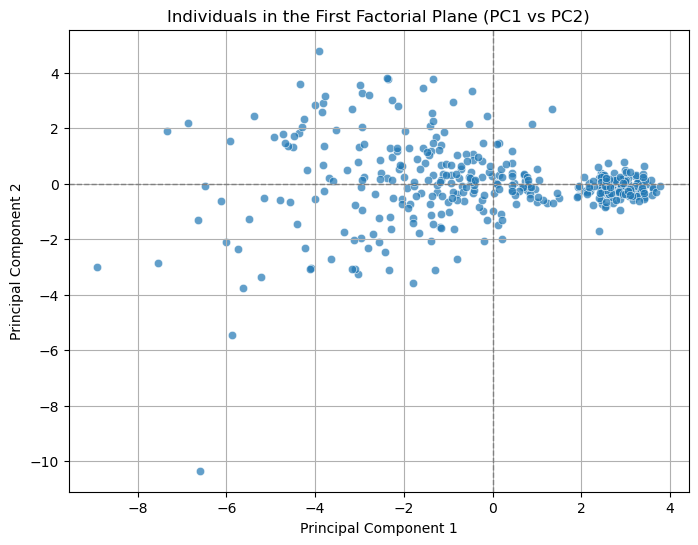

In [ ]:
pca_df = pd.DataFrame(df_pca[:, :2], columns=["PC1", "PC2"])

# Scatter plot of individuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Individuals in the First Factorial Plane (PC1 vs PC2)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.grid()
plt.show()

In [76]:
# Compute PCA loadings correctly
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Ensure that the shape is correct
print("Loadings shape:", loadings.shape)  # Should be (n_features, n_components)

# Convert to DataFrame with correct dimensions
loadings_df = pd.DataFrame(loadings[:, :2], columns=["PC1", "PC2"], index=df.columns)

# Display the loadings DataFrame
print("\n🔹 Contributions of Variables to Principal Components:\n", loadings_df)


Loadings shape: (24, 10)

🔹 Contributions of Variables to Principal Components:
                      PC1       PC2
age            -0.336589  0.161827
bp             -0.343083 -0.018456
sg              0.619162 -0.224332
al             -0.667088  0.236839
su             -0.390139  0.557159
pc              0.590217 -0.166986
pcc            -0.437424  0.304159
ba             -0.317534  0.230131
bgr            -0.456690  0.531508
bu             -0.635513 -0.424364
sc             -0.461540 -0.536528
sod             0.449984  0.372630
pot            -0.166970 -0.155790
hemo            0.838277  0.199252
pcv             0.836911  0.172468
wc             -0.221665  0.312687
rc              0.748658  0.157390
htn            -0.722766 -0.005958
dm             -0.543217  0.193041
cad            -0.382562  0.077361
appet          -0.519477 -0.024521
pe             -0.519559 -0.052944
ane            -0.511348 -0.355818
classification  0.801842 -0.066256


In [68]:
# Compute the representational qualities of individuals
representational_qualities = np.square(contributions)

In [78]:
individuals_pca = pca.transform(df)  


squared_coords = individuals_pca ** 2


total_quality = np.sum(squared_coords, axis=1)


relative_quality_pc1 = squared_coords[:, 0] / total_quality
relative_quality_pc2 = squared_coords[:, 1] / total_quality


quality_df = pd.DataFrame({
    "Total Quality": total_quality,
    "Relative Quality PC1": relative_quality_pc1,
    "Relative Quality PC2": relative_quality_pc2
})

print("\n🔹 Representational Quality of Each Individual:\n", quality_df)



🔹 Representational Quality of Each Individual:
      Total Quality  Relative Quality PC1  Relative Quality PC2
0     4.988212e+07              0.008261              0.068938
1     2.945085e+07              0.007982              0.071031
2     4.614956e+07              0.010058              0.078051
3     3.683297e+07              0.008727              0.068450
4     4.370646e+07              0.008261              0.069045
..             ...                   ...                   ...
395   3.684616e+07              0.008349              0.070564
396   4.988000e+07              0.007836              0.067838
397   3.564520e+07              0.007890              0.069433
398   4.244120e+07              0.008077              0.068683
399   3.794983e+07              0.008072              0.070855

[400 rows x 3 columns]


c:\Users\WINDOWS\anaconda3\envs\tensorflowEnv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


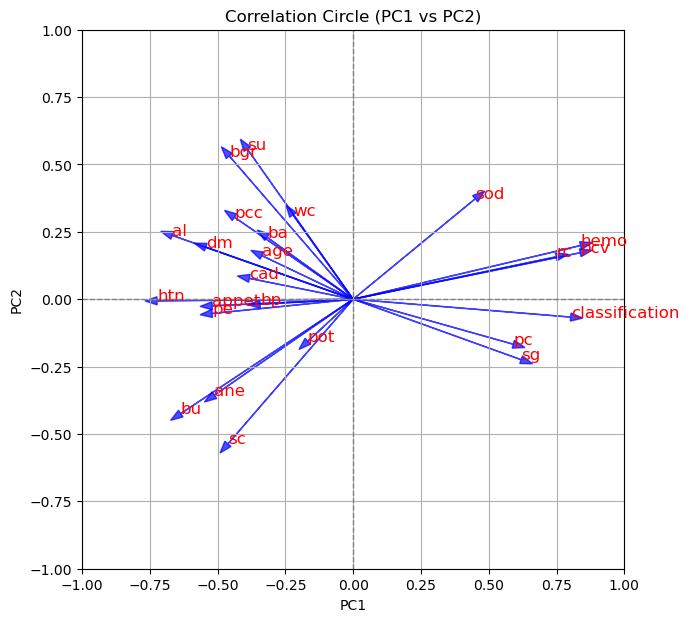

In [79]:
# Plot Correlation Circle
fig, ax = plt.subplots(figsize=(7, 7))

for i in range(loadings.shape[0]):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              color='blue', alpha=0.7, head_width=0.03)

    plt.text(loadings[i, 0], loadings[i, 1], df.columns[i], 
             color='red', fontsize=12)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Correlation Circle (PC1 vs PC2)")
plt.grid()
plt.show()


In [80]:
# Get eigenvalues
eigenvalues = pca.explained_variance_

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print eigenvalues and variance explained
eigen_df = pd.DataFrame({
    "Eigenvalue": eigenvalues,
    "Explained Variance": explained_variance_ratio,
    "Cumulative Variance": cumulative_variance
})

print("\n🔹 Eigenvalues and Variance Explained:\n", eigen_df)



🔹 Eigenvalues and Variance Explained:
    Eigenvalue  Explained Variance  Cumulative Variance
0    7.328729            0.304600             0.304600
1    1.899978            0.078968             0.383568
2    1.663267            0.069130             0.452698
3    1.328717            0.055225             0.507922
4    1.221945            0.050787             0.558710
5    1.088740            0.045251             0.603960
6    1.002419            0.041663             0.645623
7    0.922535            0.038343             0.683966
8    0.886446            0.036843             0.720809
9    0.824358            0.034262             0.755072


In [81]:
# Compute absolute correlations with PC1 and PC2
correlations = loadings_df.abs().sum(axis=1).sort_values(ascending=False)

print("\n🔹 Most Strongly Correlated Features:\n", correlations.head(5))



🔹 Most Strongly Correlated Features:
 bu      1.059877
hemo    1.037529
pcv     1.009379
sc      0.998069
bgr     0.988197
dtype: float64
